## Install neccessary libraries

In [1]:
!pip install -q -U transformers accelerate bitsandbytes langchain langchain-community pdfplumber duckduckgo-search gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB

## Login huggingface

In [ ]:
from huggingface_hub import login
login("your_secret_token")

## FIle handler

### Images captioning

#### Init blip model

In [3]:
from transformers import BlipProcessor, BlipForConditionalGeneration

blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

#### Image captioning

In [4]:
def get_image_caption(image):
    inputs = blip_processor(images=image, return_tensors="pt")
    out = blip_model.generate(**inputs)
    caption = blip_processor.decode(out[0], skip_special_tokens=True)
    return caption+"."

### Summarizer

In [6]:
from transformers import pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
#demo
text = """
The COVID-19 pandemic has had a major impact on the global economy. Governments around the world
have implemented measures to curb the spread of the virus, including lockdowns, travel restrictions,
and social distancing. These actions have led to disruptions in supply chains, decreased consumer
spending, and increased unemployment rates.
"""
summary = summarizer(text, max_length=30, min_length=5, do_sample=False)
print("Summarize:", summary[0]['summary_text'])


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


Summarize: The COVID-19 pandemic has had a major impact on the global economy. Governments around the world have implemented measures to curb the


### PDF Extractor

In [18]:
import pdfplumber
def pdf_extractor(pdf_path):
    context=[]
    with pdfplumber.open(pdf_path) as pdf:
        for pageNum,page in enumerate(pdf.pages):
            context.append(f'Page {pageNum}:')
            # Text processing
            text = page.extract_text()
            if text:
                context.extend(text.split('\n'))
            # Image processing
            page_image = page.to_image(resolution=300)
            pil_image = page_image.original
            caption = 'Image: '+get_image_caption(pil_image)
            context.append(caption)
            context.append('\n')
    context_str = " ".join([str(item) for item in context])
    #summarize if neccessary
    if len(context_str.split()) > 1000:
        summary = summarizer(
            context_str,
            max_length=200,
            min_length=50,
            do_sample=False
        )
        return summary[0]['summary_text']
    else:
        return context_str

#demo
print(pdf_extractor('/content/1mb.pdf'))


Page 0: Sample PDF This is a simple PDF file. Fun fun fun. Lorem ipsum dolor sit amet, consectetuer adipiscing elit. Phasellus facilisis odio sed mi. Curabitur suscipit. Nullam vel nisi. Etiam semper ipsum ut lectus. Proin aliquam, erat eget pharetra commodo, eros mi condimentum quam, sed commodo justo quam ut velit. Integer a erat. Cras laoreet ligula cursus enim. Aenean scelerisque velit et tellus. Vestibulum dictum aliquet sem. Nulla facilisi. Vestibulum accumsan ante vitae elit. Nulla erat dolor, blandit in, rutrum quis, semper pulvinar, enim. Nullam varius congue risus. Vivamus sollicitudin, metus ut interdum eleifend, nisi tellus pellentesque elit, tristique accumsan eros quam et risus. Suspendisse libero odio, mattis sit amet, aliquet eget, hendrerit vel, nulla. Sed vitae augue. Aliquam erat volutpat. Aliquam feugiat vulputate nisl. Suspendisse quis nulla pretium ante pretium mollis. Proin velit ligula, sagittis at, egestas a, pulvinar quis, nisl. Pellentesque sit amet lectus. P

## Generate image

### Init stable diffusion model

In [17]:
from diffusers import StableDiffusionPipeline
import torch
diffPipe=StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
).to('cuda')

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### Generate picture

  0%|          | 0/50 [00:00<?, ?it/s]

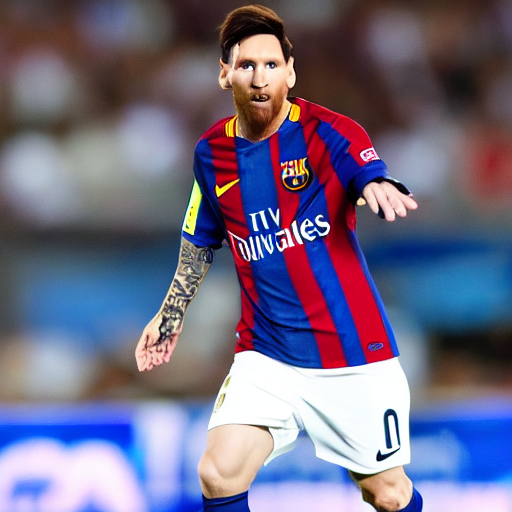

In [22]:
#demo
prompt = "Lionel Messi"
from IPython.display import display
def generate_pic(prompt):
  image = diffPipe(prompt).images[0]
  return image
image=generate_pic(prompt)
display(image)

## Main model

### Init quantized Mistral

In [23]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

model_4bit = AutoModelForCausalLM.from_pretrained( "mistralai/Mistral-7B-Instruct-v0.1", device_map="auto",quantization_config=quantization_config, )
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

### Main pipeline

In [37]:
from langchain import HuggingFacePipeline
from langchain import PromptTemplate, LLMChain
from transformers import pipeline
# pipeline
pipeline_inst = pipeline(
        "text-generation",
        model=model_4bit,
        tokenizer=tokenizer,
        use_cache=True,
        device_map="auto",
        max_length=2500,
        do_sample=True,
        top_k=5,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
)

llm = HuggingFacePipeline(pipeline=pipeline_inst)

# chain of thought
cot_prompt_template=PromptTemplate(
    input_variables=["conversation", "question","search_results","think_step_by_step","context"],
    template="""
<s>[INST] You are a thoughtful and intelligent assistant. Continue the following conversation to arrive at the correct answer.Provide only the final answer to the following question

Conversation so far:
{conversation}

User's new question:
{question}

User's context:
{context}

Relevant search results:
{search_results}

{think_step_by_step} [/INST]
""".strip()
)




Device set to use cuda:0


### Generate response

In [40]:
from langchain import LLMChain
cot_chain = LLMChain(llm=llm, prompt=cot_prompt_template)

def generate_response(chat_history,user_input,search_results="",context="",thinking=""):
    history_text = "\n".join([f"{msg[0]}: {msg[1]}" for msg in chat_history])
    response = cot_chain.run(
        conversation=history_text,
        question=user_input,
        search_results=search_results,
        think_step_by_step=thinking,
        context=context
    )

    return response.split("[/INST]")[-1].strip()

print(generate_response(["User:What is 10*3/3 ?"],"And then multiple it with 3 and divide by 2 ",thinking="Think step by step"))

User's question: And then multiple it with 3 and divide by 2.

To arrive at the correct answer, we need to follow the given instructions:

1. Start with the result of the previous calculation.
2. Multiply the result from step 1 by 3.
3. Divide the result from step 2 by 2.

Therefore, we need to multiply 11 by 3, which gives us 33. Then we divide 33 by 2, which gives us 16.5.

The final answer is 16.5.


### Conversation

In [58]:
import gradio as gr

from langchain_community.tools import DuckDuckGoSearchResults
chat_history = []
def send_message(prompt,isSearch=False,file=None,deepThink=False):
  global chat_history
  search_results=""
  context=""
  think=""
  if isSearch:
        search_tool = DuckDuckGoSearchResults(max_results=3)
        search_results = search_tool.run(prompt)
  if file:
    if(file.name.endswith(".pdf")):
      context=pdf_extractor(file.name)
    elif(file.name.endswith(".png") or file.name.endswith(".jpg")):
      context=get_image_caption(file.name)
  if deepThink:
      think="Think step by step"
  response=generate_response(chat_history,prompt,search_results,context,think)
  chat_history.append([prompt, response])
  return chat_history


def delete_history():
    global chat_history
    chat_history = []
    return "", []


def image_generate(prompt):
  image=generate_pic(prompt)
  return image

#gradio for UI
with gr.Blocks() as demo:
    gr.Markdown("Mileral")

    chatbot = gr.Chatbot(height=300)
    with gr.Row():
      user_input = gr.Textbox(placeholder="Ask me anything...", lines=1,scale=9)
      with gr.Column(scale=1):
        send_btn = gr.Button("Send",scale=1)
        clear_btn = gr.Button("Delete history",scale=1)

    with gr.Row():
        file_input = gr.File(label="Upload file",height=40)
        search = gr.Checkbox(label="Search on web")
        deepthink=gr.Checkbox(label="Deep thinking")
        image_btn = gr.Button("IMage generating")

    send_btn.click(send_message, inputs=[user_input,search,file_input,deepthink], outputs=chatbot)
    clear_btn.click(delete_history, outputs=[user_input,chatbot])
    image_btn.click(image_generate, inputs=[user_input],outputs=[chatbot])

demo.launch(share=True)

<ipython-input-58-ca8ccc02d55a>:38: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(height=300)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d7596756a6ed1614fd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
